**Chapter 15 – Recurrent Neural Networks**

_This notebook contains all the sample code in chapter 15._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


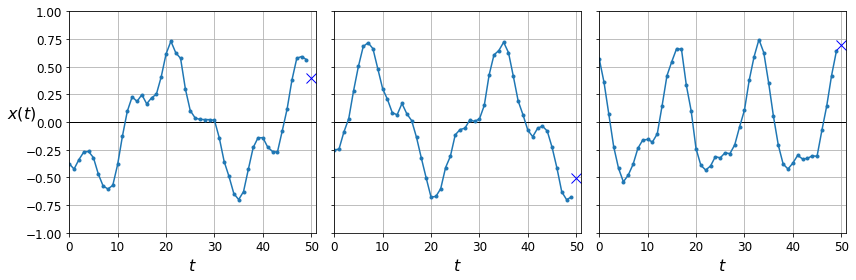

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

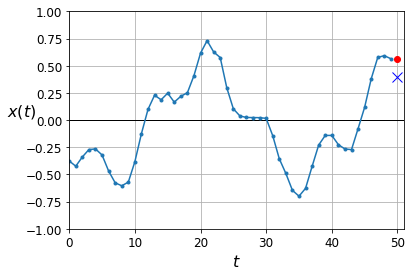

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 69us/sample - loss: 0.1015 - val_loss: 0.0551
Epoch 2/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0384 - val_loss: 0.0267
Epoch 3/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0205 - val_loss: 0.0161
Epoch 4/20
7000/7000 [==============================] - 0s 33us/sample - loss: 0.0133 - val_loss: 0.0119
Epoch 5/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0104 - val_loss: 0.0099
Epoch 6/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0090 - val_loss: 0.0088
Epoch 7/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0081 - val_loss: 0.0079
Epoch 8/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0073 - val_loss: 0.0074
Epoch 9/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0067 - val_loss: 0.0066
Epoch 1

In [9]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 16us/sample - loss: 0.0042


0.00417404793202877

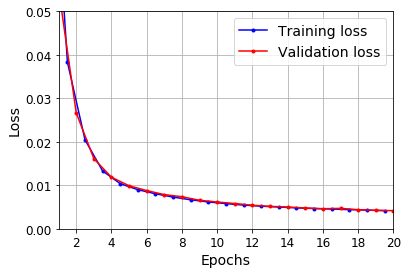

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

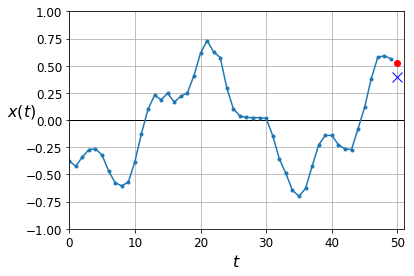

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 368us/sample - loss: 0.0960 - val_loss: 0.0482
Epoch 2/20
7000/7000 [==============================] - 2s 262us/sample - loss: 0.0366 - val_loss: 0.0293
Epoch 3/20
7000/7000 [==============================] - 2s 260us/sample - loss: 0.0251 - val_loss: 0.0216
Epoch 4/20
7000/7000 [==============================] - 2s 260us/sample - loss: 0.0196 - val_loss: 0.0175
Epoch 5/20
7000/7000 [==============================] - 2s 261us/sample - loss: 0.0165 - val_loss: 0.0150
Epoch 6/20
7000/7000 [==============================] - 2s 272us/sample - loss: 0.0145 - val_loss: 0.0133
Epoch 7/20
7000/7000 [==============================] - 2s 268us/sample - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
7000/7000 [==============================] - 2s 277us/sample - loss: 0.0123 - val_loss: 0.0116
Epoch 9/20
7000/7000 [==============================] - 2s 276us/sample - loss: 0.0118 - val_loss: 0.011

In [13]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 73us/sample - loss: 0.0108


0.010848855562508107

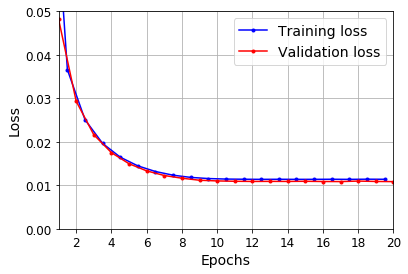

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

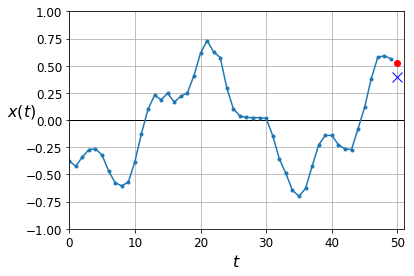

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0502 - val_loss: 0.0093
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0069 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0050 - val_loss: 0.0044
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0048 - val_loss: 0.0040
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0041 - val_loss: 0.0037
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0041 - val_loss: 0.0043
Epoch 7/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0038 - val_loss: 0.0036
Epoch 8/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0037 - val_loss: 0.0032
Epoch 9/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 10/20
700

In [17]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 283us/sample - loss: 0.0029


0.002889613388106227

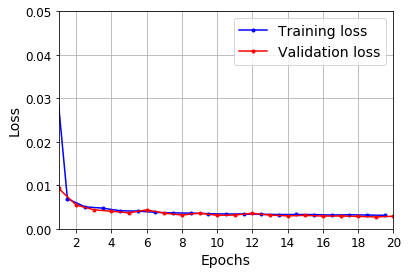

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

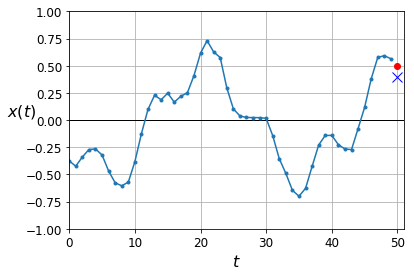

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 988us/sample - loss: 0.0212 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 6s 834us/sample - loss: 0.0041 - val_loss: 0.0034
Epoch 3/20
7000/7000 [==============================] - 6s 811us/sample - loss: 0.0034 - val_loss: 0.0031
Epoch 4/20
7000/7000 [==============================] - 5s 776us/sample - loss: 0.0033 - val_loss: 0.0030
Epoch 5/20
7000/7000 [==============================] - 6s 838us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 5s 764us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 7/20
7000/7000 [==============================] - 6s 830us/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 6s 847us/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 5s 773us/sample - loss: 0.0030 - val_loss: 0.003

In [21]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 185us/sample - loss: 0.0027


0.0026770312264561653

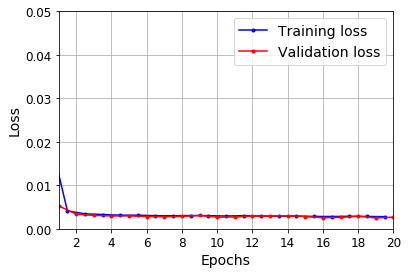

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

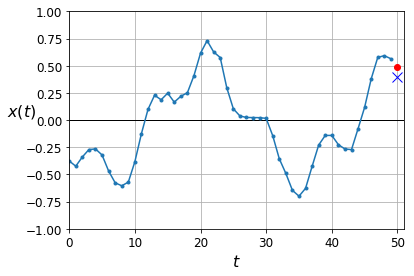

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [24]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [25]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


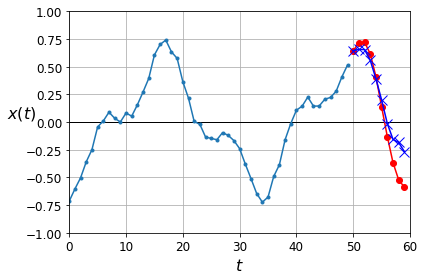

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 10 next values at once:

In [27]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:]

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
    keras.layers.Lambda(lambda Y_pred: Y_pred[:, -10:])
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 966us/sample - loss: 0.0633 - val_loss: 0.0380
Epoch 2/20
7000/7000 [==============================] - 5s 774us/sample - loss: 0.0331 - val_loss: 0.0279
Epoch 3/20
7000/7000 [==============================] - 5s 762us/sample - loss: 0.0264 - val_loss: 0.0256
Epoch 4/20
7000/7000 [==============================] - 5s 775us/sample - loss: 0.0229 - val_loss: 0.0216
Epoch 5/20
7000/7000 [==============================] - 5s 765us/sample - loss: 0.0219 - val_loss: 0.0213
Epoch 6/20
7000/7000 [==============================] - 5s 752us/sample - loss: 0.0211 - val_loss: 0.0210
Epoch 7/20
7000/7000 [==============================] - 5s 735us/sample - loss: 0.0210 - val_loss: 0.0194
Epoch 8/20
7000/7000 [==============================] - 5s 737us/sample - loss: 0.0204 - val_loss: 0.0197
Epoch 9/20
7000/7000 [==============================] - 5s 740us/sample - loss: 0.0201 - val_loss: 0.019

In [29]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[:, -10:, :]

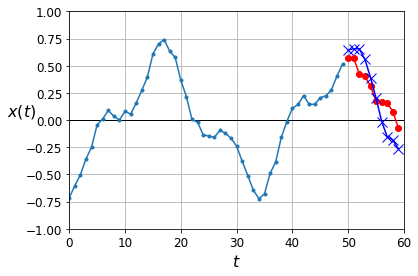

In [30]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the input sequence, shifted 10 steps into the future. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 10 to 59 based on time steps 0 to 49 (the time steps 10 to 49 are in the input, but the model is causal so at any time step it cannot see the future inputs):

In [31]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, 10:]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, 10:]
X_test, Y_test = series[9000:, :n_steps], series[9000:, 10:]

In [32]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 1))

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

def last_10_time_steps_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -10:], Y_pred[:, -10:])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0771 - last_10_time_steps_mse: 0.0677 - val_loss: 0.0576 - val_last_10_time_steps_mse: 0.0460
Epoch 2/20
7000/7000 [==============================] - 6s 822us/sample - loss: 0.0552 - last_10_time_steps_mse: 0.0428 - val_loss: 0.0521 - val_last_10_time_steps_mse: 0.0385
Epoch 3/20
7000/7000 [==============================] - 6s 812us/sample - loss: 0.0511 - last_10_time_steps_mse: 0.0367 - val_loss: 0.0516 - val_last_10_time_steps_mse: 0.0371
Epoch 4/20
7000/7000 [==============================] - 6s 819us/sample - loss: 0.0480 - last_10_time_steps_mse: 0.0332 - val_loss: 0.0461 - val_last_10_time_steps_mse: 0.0308
Epoch 5/20
7000/7000 [==============================] - 6s 805us/sample - loss: 0.0452 - last_10_time_steps_mse: 0.0300 - val_loss: 0.0437 - val_last_10_time_steps_mse: 0.0279
Epoch 6/20
7000/7000 [==============================] - 6s 798us/sample - 

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -10:, :]

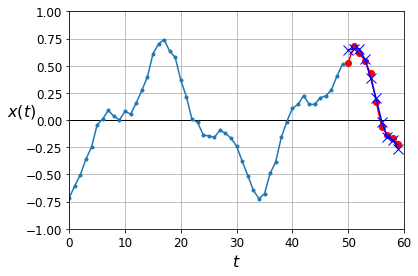

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [36]:
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0947 - last_10_time_steps_mse: 0.0791 - val_loss: 0.0808 - val_last_10_time_steps_mse: 0.0747
Epoch 2/20
7000/7000 [==============================] - 6s 862us/sample - loss: 0.0549 - last_10_time_steps_mse: 0.0438 - val_loss: 0.0570 - val_last_10_time_steps_mse: 0.0469
Epoch 3/20
7000/7000 [==============================] - 6s 789us/sample - loss: 0.0507 - last_10_time_steps_mse: 0.0392 - val_loss: 0.0517 - val_last_10_time_steps_mse: 0.0394
Epoch 4/20
7000/7000 [==============================] - 5s 775us/sample - loss: 0.0481 - last_10_time_steps_mse: 0.0360 - val_loss: 0.0468 - val_last_10_time_steps_mse: 0.0344
Epoch 5/20
7000/7000 [==============================] - 6s 812us/sample - loss: 0.0464 - last_10_time_steps_mse: 0.0337 - val_loss: 0.0459 - val_last_10_time_steps_mse: 0.0326
Epoch 6/20
7000/7000 [==============================] - 6s 787us/sample - 

# Deep RNNs with Layer Norm

In [37]:
from tensorflow.keras.layers.experimental import LayerNormalization

In [38]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.1177 - last_10_time_steps_mse: 0.1019 - val_loss: 0.0705 - val_last_10_time_steps_mse: 0.0652
Epoch 2/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0647 - last_10_time_steps_mse: 0.0570 - val_loss: 0.0593 - val_last_10_time_steps_mse: 0.0506
Epoch 3/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0563 - last_10_time_steps_mse: 0.0453 - val_loss: 0.0533 - val_last_10_time_steps_mse: 0.0420
Epoch 4/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0507 - last_10_time_steps_mse: 0.0380 - val_loss: 0.0472 - val_last_10_time_steps_mse: 0.0340
Epoch 5/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0467 - last_10_time_steps_mse: 0.0333 - val_loss: 0.0447 - val_last_10_time_steps_mse: 0.0315
Epoch 6/20
7000/7000 [==============================] - 12s 2ms/sample - loss

# Creating a Custom RNN Class

In [40]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.1448 - last_10_time_steps_mse: 0.1458 - val_loss: 0.0818 - val_last_10_time_steps_mse: 0.0752
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0756 - last_10_time_steps_mse: 0.0691 - val_loss: 0.0707 - val_last_10_time_steps_mse: 0.0645
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0681 - last_10_time_steps_mse: 0.0601 - val_loss: 0.0641 - val_last_10_time_steps_mse: 0.0534
Epoch 4/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0606 - last_10_time_steps_mse: 0.0498 - val_loss: 0.0580 - val_last_10_time_steps_mse: 0.0453
Epoch 5/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0564 - last_10_time_steps_mse: 0.0440 - val_loss: 0.0540 - val_last_10_time_steps_mse: 0.0413
Epoch 6/20
7000/7000 [==============================] - 13s 2ms/sample - loss

# LSTMs

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0806 - last_10_time_steps_mse: 0.0764 - val_loss: 0.0692 - val_last_10_time_steps_mse: 0.0621
Epoch 2/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0653 - last_10_time_steps_mse: 0.0559 - val_loss: 0.0589 - val_last_10_time_steps_mse: 0.0460
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0526 - last_10_time_steps_mse: 0.0371 - val_loss: 0.0487 - val_last_10_time_steps_mse: 0.0313
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0464 - last_10_time_steps_mse: 0.0290 - val_loss: 0.0460 - val_last_10_time_steps_mse: 0.0290
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0437 - last_10_time_steps_mse: 0.0261 - val_loss: 0.0422 - val_last_10_time_steps_mse: 0.0240
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss

In [43]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 1s 749us/sample - loss: 0.0348 - last_10_time_steps_mse: 0.0163


[0.03475927668809891, 0.016288176]

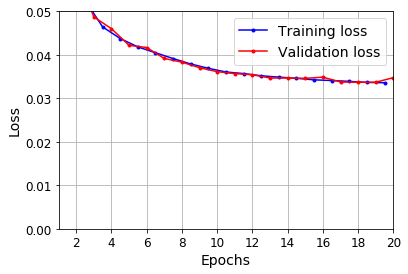

In [44]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [45]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -10:, :]

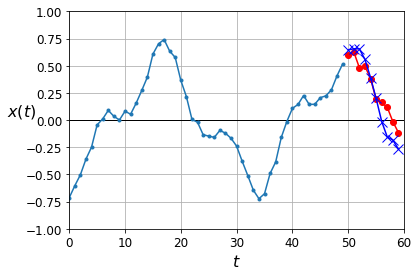

In [46]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0805 - last_10_time_steps_mse: 0.0783 - val_loss: 0.0716 - val_last_10_time_steps_mse: 0.0682
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0701 - last_10_time_steps_mse: 0.0657 - val_loss: 0.0684 - val_last_10_time_steps_mse: 0.0641
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0648 - last_10_time_steps_mse: 0.0589 - val_loss: 0.0605 - val_last_10_time_steps_mse: 0.0525
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0558 - last_10_time_steps_mse: 0.0445 - val_loss: 0.0515 - val_last_10_time_steps_mse: 0.0374
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0489 - last_10_time_steps_mse: 0.0337 - val_loss: 0.0468 - val_last_10_time_steps_mse: 0.0300
Epoch 6/20
7000/7000 [==============================] - 14s 2ms/sample - loss

In [48]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 2s 767us/sample - loss: 0.0346 - last_10_time_steps_mse: 0.0180


[0.03462266159057617, 0.018013379]

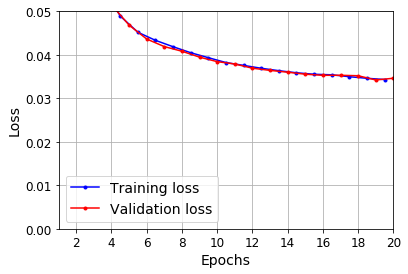

In [49]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [50]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -10:, :]

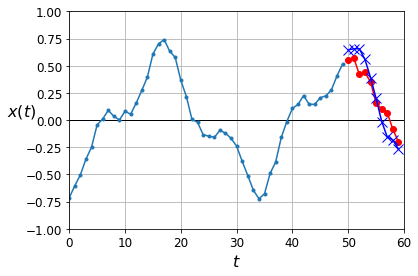

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2----|      |-----5---...         |----23-----|
        |-----1----|      |-----4-----|   ...   |-----22----|
  |-----0----|      |-----3----|      |---...-21---|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59

Output:

X: 0  1  2  3  4  5  ... 19 20 21 22 23
Y: 13 15 17 19 21 23 ... 51 53 55 57 59
```

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

def last_5_time_steps_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -5:], Y_pred[:, -5:])

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="VALID",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_5_time_steps_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0792 - last_5_time_steps_mse: 0.0762 - val_loss: 0.0696 - val_last_5_time_steps_mse: 0.0649
Epoch 2/20
7000/7000 [==============================] - 6s 922us/sample - loss: 0.0638 - last_5_time_steps_mse: 0.0597 - val_loss: 0.0576 - val_last_5_time_steps_mse: 0.0533
Epoch 3/20
7000/7000 [==============================] - 7s 964us/sample - loss: 0.0517 - last_5_time_steps_mse: 0.0453 - val_loss: 0.0474 - val_last_5_time_steps_mse: 0.0397
Epoch 4/20
7000/7000 [==============================] - 7s 930us/sample - loss: 0.0463 - last_5_time_steps_mse: 0.0389 - val_loss: 0.0449 - val_last_5_time_steps_mse: 0.0368
Epoch 5/20
7000/7000 [==============================] - 7s 929us/sample - loss: 0.0430 - last_5_time_steps_mse: 0.0350 - val_loss: 0.0414 - val_last_5_time_steps_mse: 0.0327
Epoch 6/20
7000/7000 [==============================] - 6s 922us/sample - loss: 0.04

## WaveNet

```
C2     /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\ 
      /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59

Output:

X: 0  1  2  3  4  5  ... 19 20 21 22 23
Y: 13 15 17 19 21 23 ... 51 53 55 57 59
```

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Lambda(
        lambda inputs: keras.backend.temporal_padding(inputs, (rate, 0))))
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="VALID",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 572us/sample - loss: 0.0636 - last_10_time_steps_mse: 0.0549 - val_loss: 0.0445 - val_last_10_time_steps_mse: 0.0319
Epoch 2/20
7000/7000 [==============================] - 2s 308us/sample - loss: 0.0402 - last_10_time_steps_mse: 0.0266 - val_loss: 0.0379 - val_last_10_time_steps_mse: 0.0240
Epoch 3/20
7000/7000 [==============================] - 2s 307us/sample - loss: 0.0366 - last_10_time_steps_mse: 0.0222 - val_loss: 0.0360 - val_last_10_time_steps_mse: 0.0216
Epoch 4/20
7000/7000 [==============================] - 2s 310us/sample - loss: 0.0347 - last_10_time_steps_mse: 0.0198 - val_loss: 0.0329 - val_last_10_time_steps_mse: 0.0174
Epoch 5/20
7000/7000 [==============================] - 2s 303us/sample - loss: 0.0326 - last_10_time_steps_mse: 0.0170 - val_loss: 0.0312 - val_last_10_time_steps_mse: 0.0153
Epoch 6/20
7000/7000 [==============================] - 2s 306us/sample 

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [54]:
from tensorflow import keras

class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [55]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.backend.temporal_padding(inputs, (dilation_rate, 0))
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2,
                            dilation_rate=dilation_rate)(z)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 10
n_blocks = 3
n_filters = 128
n_outputs = 256

inputs = keras.layers.Input(shape=[None, 1])
z = keras.backend.temporal_padding(inputs, (1, 0))
z = keras.layers.Conv1D(n_filters, kernel_size=2)(z)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [57]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=2, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 265s 38ms/sample - loss: 0.0781 - val_loss: 2.6106e-05
Epoch 2/2
7000/7000 [==============================] - 276s 39ms/sample - loss: 2.6106e-05 - val_loss: 2.6106e-05


### Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


# Char-RNN

In [59]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [60]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [61]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [62]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [63]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [64]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [65]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [66]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [67]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [68]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [69]:
np.random.seed(42)
tf.random.set_seed(42)

In [70]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [71]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [72]:
dataset = dataset.prefetch(1)

In [73]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


In [74]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Epoch 1/10
31370/31370 [==============================] - 6063s 193ms/step - loss: 1.7662
Epoch 2/10
31370/31370 [==============================] - 5744s 183ms/step - loss: 1.6649
Epoch 3/10
31370/31370 [==============================] - 5320s 170ms/step - loss: 1.6508
Epoch 4/10
31370/31370 [==============================] - 5318s 170ms/step - loss: 1.6400
Epoch 5/10
31370/31370 [==============================] - 5318s 170ms/step - loss: 1.6359
Epoch 6/10
31370/31370 [==============================] - 5316s 169ms/step - loss: 1.6344
Epoch 7/10
31370/31370 [==============================] - 5489s 175ms/step - loss: 1.6336
Epoch 8/10
31370/31370 [==============================] - 5638s 180ms/step - loss: 1.6277
Epoch 9/10
31370/31370 [==============================] - 5709s 182ms/step - loss: 1.6309
Epoch 10/10
31370/31370 [==============================] - 6107s 195ms/step - loss: 1.6317


In [75]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [76]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [77]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

In [78]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [79]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [80]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [81]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the belly the great and who shall be the belly the 


In [82]:
print(complete_text("t", temperature=1))

thing? or why you gremio.
who make which the first 


In [83]:
print(complete_text("t", temperature=2))

th no cce:
yeolg-hormer firi. a play asks.
fol rusb


### Stateful RNN

In [84]:
tf.random.set_seed(42)

In [85]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [86]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [87]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
#                     dropout=0.2, recurrent_dropout=0.2, # see TF issue #27829
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True
#                     dropout=0.2, recurrent_dropout=0.2 # see TF issue #27829
                    ),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [88]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [89]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                   callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 37s 118ms/step - loss: 2.4841
Epoch 2/50
313/313 [==============================] - 35s 110ms/step - loss: 1.9857
Epoch 3/50
313/313 [==============================] - 34s 110ms/step - loss: 1.7911
Epoch 4/50
313/313 [==============================] - 34s 110ms/step - loss: 1.6789
Epoch 5/50
313/313 [==============================] - 36s 114ms/step - loss: 1.6067
Epoch 6/50
313/313 [==============================] - 39s 124ms/step - loss: 1.5517
Epoch 7/50
313/313 [==============================] - 42s 133ms/step - loss: 1.5078
Epoch 8/50
313/313 [==============================] - 42s 134ms/step - loss: 1.4756
Epoch 9/50
313/313 [==============================] - 41s 132ms/step - loss: 1.4502
Epoch 10/50
313/313 [==============================] - 41s 130ms/step - loss: 1.4291
Epoch 11/50
313/313 [==============================] - 40s 129ms/step - loss: 1.4114
Epoch 12/50
313/313 [==============================] - 40s 126ms/step - lo

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [90]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [91]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [92]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [93]:
tf.random.set_seed(42)

print(complete_text("t"))

tham!

coriolanus:
my loyald them done, live,
the c


# Sentiment Analysis

In [94]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [95]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

In [96]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [97]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In [98]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [99]:
datasets.keys()

dict_keys(['test', 'train'])

In [100]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [101]:
train_size, test_size

(25000, 25000)

In [102]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was soul-provoking! I am an Iranian, and living in th 21st century, I didn't know that such big tribes have been living in such conditions at the time of my grandfather!<br /><br />You see that t ...
Label: 1 = Positive

Review: A very close and sharp discription of the bubbling and dynamic emotional world of specialy one 18year old guy, that makes his first experiences in his gay love to an other boy, during an vacation with ...
Label: 1 = Positive



In [103]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [104]:
preprocess(X_batch, y_batch)

(<tf.Tensor: id=235, shape=(2, 57), dtype=string, numpy=
 array([[b'This', b'was', b'soul', b'provoking', b'I', b'am', b'an',
         b'Iranian', b'and', b'living', b'in', b'th', b'st', b'century',
         b'I', b"didn't", b'know', b'that', b'such', b'big', b'tribes',
         b'have', b'been', b'living', b'in', b'such', b'conditions',
         b'at', b'the', b'time', b'of', b'my', b'grandfather', b'You',
         b'see', b'that', b'today', b'or', b'even', b'in', b'on', b'one',
         b'side', b'of', b'the', b'world', b'a', b'lady', b'or', b'a',
         b'baby', b'could', b'have', b'everything', b'served', b'for',
         b'hi'],
        [b'A', b'very', b'close', b'and', b'sharp', b'discription', b'of',
         b'the', b'bubbling', b'and', b'dynamic', b'emotional', b'world',
         b'of', b'specialy', b'one', b'year', b'old', b'guy', b'that',
         b'makes', b'his', b'first', b'experiences', b'in', b'his',
         b'gay', b'love', b'to', b'an', b'other', b'boy', b'during',

In [105]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [106]:
vocabulary.most_common()[:3]

[(b'<pad>', 214077), (b'the', 61137), (b'a', 38564)]

In [107]:
len(vocabulary)

53893

In [108]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [109]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [110]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [111]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: id=126936, shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [112]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [113]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[    6    98     9 ...     0     0     0]
 [  185     2 10865 ...     0     0     0]
 [  719  2410  5630 ...     0     0     0]
 ...
 [    6    94    13 ...     0     0     0]
 [   14   498    16 ...     0     0     0]
 [  168     1  1633 ...     0     0     0]], shape=(32, 64), dtype=int64)
tf.Tensor([1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0], shape=(32,), dtype=int64)


In [114]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 102s 131ms/step - loss: 0.5378 - accuracy: 0.7238
Epoch 2/5
781/781 [==============================] - 87s 111ms/step - loss: 0.3485 - accuracy: 0.8567
Epoch 3/5
781/781 [==============================] - 87s 111ms/step - loss: 0.1877 - accuracy: 0.9332
Epoch 4/5
781/781 [==============================] - 87s 111ms/step - loss: 0.1236 - accuracy: 0.9573
Epoch 5/5
781/781 [==============================] - 87s 111ms/step - loss: 0.0964 - accuracy: 0.9667


Or using manual masking:

In [115]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 102s 131ms/step - loss: 0.5436 - accuracy: 0.7172
Epoch 2/5
781/781 [==============================] - 88s 113ms/step - loss: 0.3519 - accuracy: 0.8564
Epoch 3/5
781/781 [==============================] - 87s 111ms/step - loss: 0.1950 - accuracy: 0.9306
Epoch 4/5
781/781 [==============================] - 87s 111ms/step - loss: 0.1226 - accuracy: 0.9579
Epoch 5/5
781/781 [==============================] - 86s 110ms/step - loss: 0.0922 - accuracy: 0.9679


## Reusing Pretrained Embeddings

In [116]:
tf.random.set_seed(42)

In [117]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [118]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [119]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [120]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 119s 152ms/step - loss: 0.5499 - accuracy: 0.7230
Epoch 2/5
781/781 [==============================] - 119s 152ms/step - loss: 0.5133 - accuracy: 0.7486
Epoch 3/5
781/781 [==============================] - 117s 150ms/step - loss: 0.5078 - accuracy: 0.7518
Epoch 4/5
781/781 [==============================] - 118s 151ms/step - loss: 0.5042 - accuracy: 0.7540
Epoch 5/5
781/781 [==============================] - 122s 156ms/step - loss: 0.5010 - accuracy: 0.7574


## Automatic Translation

In [121]:
tf.random.set_seed(42)

In [122]:
vocab_size = 100
embed_size = 10

In [123]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [124]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [125]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
1000/1000 [==============================] - 6s 6ms/sample - loss: 4.6054
Epoch 2/2
1000/1000 [==============================] - 5s 5ms/sample - loss: 4.6041

### Bidirectional Recurrent Layers

In [126]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Positional Encoding

In [127]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [128]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

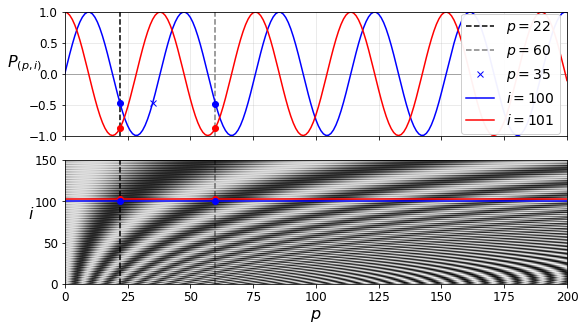

In [129]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [130]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

In [131]:
for N in range(6):
    encoder_attn = keras.layers.Attention(use_scale=True)
    encoder_in = encoder_attn([encoder_in, encoder_in])
    masked_decoder_attn = keras.layers.Attention(use_scale=True, causal=True)
    decoder_in = masked_decoder_attn([decoder_in, decoder_in])
    decoder_attn = keras.layers.Attention(use_scale=True)
    final_enc = decoder_attn([decoder_in, encoder_in])

output_layer = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))
outputs = output_layer(final_enc)

# Exercise solutions

## 1. to 6.

See Appendix A.

## 7. Embedded Reber Grammars

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [132]:
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [133]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [134]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE BPBTSSSSSXXTTVPXVPXTTTVVEPE BPBTSSXXTVPSEPE BPBPTTTTTTTVPSEPE BTBTSXSETE BPBPTVPXVVEPE BPBPVVEPE BPBPTVVEPE BTBPTTVPXTTVPSETE BTBTSSXSETE BTBTXXTTVVETE BPBTSXSEPE BPBPTVPSEPE BTBPVVETE BPBTXXTTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [135]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [136]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTTTXXVVETE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS 

To be continued...